In [38]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Paths

In [1]:
pwd

'/home/v_chernyy/thesis/notebooks'

In [2]:
import sys
sys.path.append('/home/v_chernyy/thesis')

## Models

In [3]:
from models.supervised_models import LitDeepLabV2

ModuleNotFoundError: No module named 'models.supervised_models'

In [42]:
models_list = [LitDeepLabV2.load_from_checkpoint(f'../pretrained/deeplab_v2/model{i}.ckpt').cpu() for i in range(1, 4)]
len(models_list)

3

## Data

In [43]:
SIEMENS_PATH = '/raid/data/DA_BrainDataset/siemens3/df_save.csv'
PHILIPS_PATH = '/home/v_chernyy/thesis/dataframes/philips3_cleaned.csv' # '/raid/data/DA_BrainDataset/philips3/df_save.csv'

In [44]:
BATCH_SIZE=25

In [8]:
from torchvision import transforms as TT
from data import SegmentationDataset, get_train_test_split_loaders

transforms = TT.Compose([
    TT.ToTensor()
])

dataset_A = SegmentationDataset(
    dataframe_path = SIEMENS_PATH,
    transform=transforms,
    mask_transform=transforms
)

dataset_B = SegmentationDataset(
    dataframe_path = PHILIPS_PATH,
    transform=transforms,
    mask_transform=transforms
)

trainA_loader, testA_loader = get_train_test_split_loaders(
    dataset_A, batch_size=BATCH_SIZE, test_size=0.2
)

trainB_loader, testB_loader = get_train_test_split_loaders(
    dataset_B, batch_size=BATCH_SIZE, test_size=0.2
)

TypeError: __init__() got an unexpected keyword argument 'dataframe_path'

In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('/raid/data/DA_BrainDataset/siemens3/df_save.csv')

In [4]:
from models.seg_wrapper import sdice

In [23]:
import torchvision.transforms as TT
import torch

mask = TT.PILToTensor()(Image.open(df.iloc[bad_lines[0]]['mask'])).squeeze()
pred_mask = torch.ones_like(mask)

sdice(mask, pred_mask)

0.0

In [1]:
!ls /raid/data/DA_BrainDataset/ge3

df_save.csv  mask  train


In [12]:
domain = 'siemens15'

In [13]:
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

df = pd.read_csv(f'/raid/data/CC359/{domain}/df_save.csv')

bad_lines = []

for line in tqdm(df.iterrows(), total=df.shape[0]):

    mask = np.asarray(Image.open(line[1]['mask']))
    if mask.sum() == 0:
        bad_lines.append(line[0])

df = df[~df.index.isin(bad_lines)]

print(f'{len(bad_lines) / df.shape[0] * 100:.2f}% of lines filtered')

test_scans = df.file_id.unique()[-2::]

df['fold'] = 'none'

for line in tqdm(df.iterrows(), total=df.shape[0]):
    df.loc[line[0], 'fold'] = 'train' if line[1].file_id not in test_scans else 'test'

df.to_csv(f'/home/v_chernyy/thesis/dataframes/{domain}.csv')

100%|██████████| 10320/10320 [00:07<00:00, 1400.87it/s]


23.15% of lines filtered


100%|██████████| 8380/8380 [00:01<00:00, 5474.56it/s]


In [22]:
from models.seg_wrapper import LitSegNet, sdice

In [23]:
model = LitSegNet(num_classes=2, n_epochs=-1)

In [26]:
idx = 0

a = dataset_B[idx]['img'][0]
b = dataset_B[idx]['mask'][0]

print(sdice(a, a))

1.0


## Method

In [27]:
import torch
import gc

torch.cuda.empty_cache(), gc.collect()

(None, 512)

In [82]:
from sklearn.manifold import TSNE

import torch.nn as nn
import torch

import copy

from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

def get_latent(model, loaderA, loaderB, device, to_plot=False):
    model = copy.deepcopy(model)
    model.to(device)
    
    latent_list = []
    label_list = []

    with torch.no_grad():

        for batch in tqdm(loaderA):

            latent = model(batch['img'].cuda()).detach().cpu().flatten(start_dim=1)

            latent_list.append(latent)
            label_list += [0] * batch['img'].shape[0]

        for batch in tqdm(loaderB):

            latent = model(batch['img'].cuda()).detach().cpu().flatten(start_dim=1)

            latent_list.append(latent)
            label_list += [1] * batch['img'].shape[0]

    latents = torch.concat(latent_list, 0)
    labels = np.array(label_list)
    
    latent_embedded = TSNE(n_components=2).fit_transform(latents)

    if to_plot:
        plt.figure(figsize = (7, 5))

        plt.scatter(latent_embedded[:, 0], latent_embedded[:, 1], c=labels, alpha=0.2)
        plt.axis('off')

        plt.show()
    
    return latent_embedded, labels

cuda:0


In [83]:
latent_1, labels = get_latent(models_list[0].model, testA_loader, testB_loader, DEVICE, to_plot=False)

latent_2, _ = get_latent(models_list[1].model, testA_loader, testB_loader, DEVICE, to_plot=False)

latent_3, _ = get_latent(models_list[2].model, testA_loader, testB_loader, DEVICE, to_plot=False)

  0%|          | 0/83 [00:00<?, ?it/s]/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
  0%|          | 0/83 [00:00<?, ?it/s]/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
  0%|          | 0/83 [00:00<?, ?it/s]/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note 

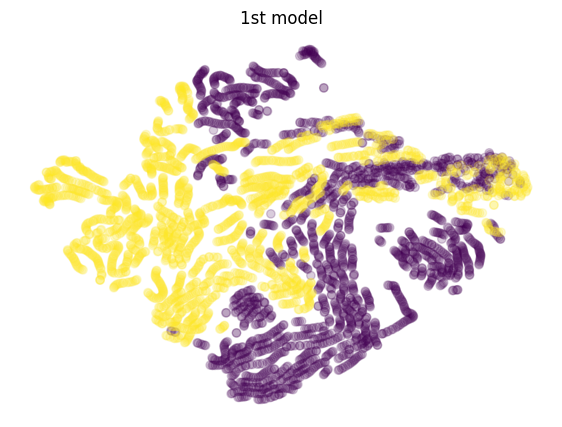

In [84]:
plt.figure(figsize = (7, 5))
plt.title('1st model')

plt.scatter(latent_1[:, 0], latent_1[:, 1], c=labels, alpha=0.2)
plt.axis('off')

plt.show()

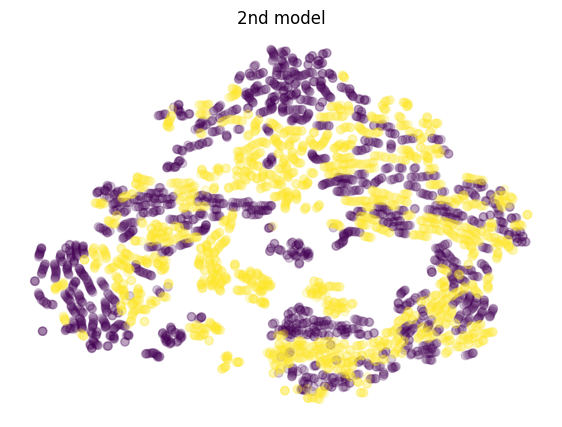

In [85]:
plt.figure(figsize = (7, 5))
plt.title('2nd model')

plt.scatter(latent_2[:, 0], latent_2[:, 1], c=labels, alpha=0.2)
plt.axis('off')

plt.show()

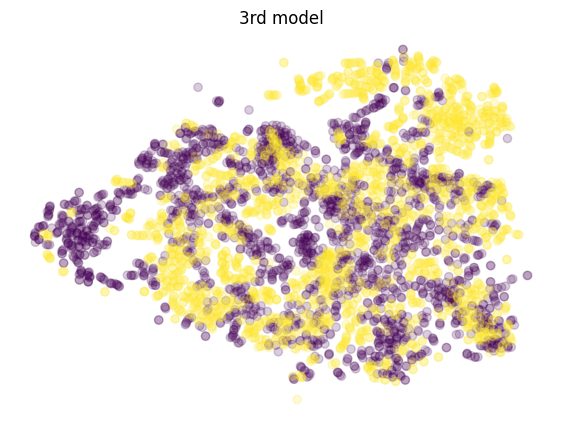

In [87]:
plt.figure(figsize = (7, 5))
plt.title('3rd model')

plt.scatter(latent_3[:, 0], latent_3[:, 1], c=labels, alpha=0.2)
plt.axis('off')

plt.show()